<a href="https://colab.research.google.com/github/Nielspace/AI-From-Scratch/blob/master/Transfer%5C%20Learning/02_Transfer_Learning_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Tranfer with Deep Learning

In this notebook, I will *recreate or develop* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

I will try to break down each and every steps for a more intuitive knowledge. I will show you how you can break a paper into its fundamental constituents.

Well, our approach will be all be modifying a CNN architecture. 

## So what is a style transfer?
Style transfer is a method of modifying a picture by adopting a style from some other image. We are already using this technique in softwares like photoshop, coral and what not. 

The idea and inspiration behind this project is to use neural nets to capture some of the minor details from the style image and deploy it on the orginal image. 

For that purpose we use Convolutional neural nets. Why? Because, CNN contains layers and each of those layers acts like a filter which allows us to extract features required for the final results or rendering. 

<img src='https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/notebook_ims/vgg19_convlayers.png' width=80% />

In this notebook, I will use a pre-trained VGG19 Net to extract content or style features from a passed in image. Then formalize the idea of content and <code>style _losses_ </code> and use those to iteratively update our target image until we get a result that we want. 



# Importing modules

In [0]:
import numpy as np

import torch
import torch.optim as optim
import torchvision as tv

import matplotlib.pyplot as plt
from PIL import Image

# Transfer Learning with VGG19

Transfer learning is a machine learning method where a model developed for a particular task is reused as the starting point for a model on a second task.

## Why?
Because of variety of reasons:
  1. We are not able to produce a good model for our specific requirements.
  2. We want a to develop a quick model which will meet our requirements. 
  3. What if the model of our particular requirements is already out there, all we need to do is to get the require data and train the model with the same. We don't want to re-invent the wheel again. 


This approach is used popularly in: 
  1. Computer Vision 
  2. Natuaral Language processing


## VGG19

VGG19 is split into two portions:

- vgg19.features -- refers to all the convolutional and pooling layers

- vgg19.classifier -- refers to linear layers
    - Dense layers
    - output layers

I will be using features only so that I can extract the styling details and **make my way to optimse the output image**. For that very reason not using the linear layers. 

*Note: We will not optimise any parameter becauese of the reasons mentioned above.* 

In [0]:
vgg = tv.models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False) #freezing the parameters, no optimization will take place. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
#Checking on device we are in. 

device

device(type='cuda')

# Loading the content and style images

Content Image is the image that we want to modify and style image is the image which is used to extract the layers and modify the content image

In [0]:
def load_image(img_path, max_size=512, shape=None):
    """
    Todo:

      1. Check the size, if the size is more than 512px then resize the image to 512px.
      2. Convert to tensor
      3. Normalise the image
    
    """

    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    img_transform = tv.transforms.Compose([
                        tv.transforms.Resize(size),
                        tv.transforms.ToTensor(),
                        tv.transforms.Normalize((0.485, 0.456, 0.406), #mean of each channel i.e RGB 
                                             (0.229, 0.224, 0.225))]) #std deviation of each channel

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = img_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
!ls

abstract-abstract-painting-acrylic-acrylic-paint-1585325.jpg  b.jpg
a.jpg							      sample_data


In [27]:
# load in content and style image
content = load_image('d.jpg').to(device)
content.shape

torch.Size([1, 3, 768, 512])

In [42]:
style = load_image('b.jpg', shape=content.shape[-2:]).to(device)
style.shape

torch.Size([1, 3, 768, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


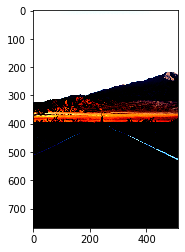

In [43]:
plt.imshow(content.cpu().numpy().squeeze().transpose(1,2,0))

In [0]:
def im_convert(tensor):
    """ 
    Display a tensor as an image. 
    
    1. make sure to convert the cuda tensor to cpu tensor 
    2. to plot a graph make sure to use numpy array
    3. make sure that the size is transpose to 1,2,0 inorder to get a matrix of n*n -- a square matrix 

    How np.transpose works???
    
    > x = np.array([[[1,2,3],
              [3,4,2],
              [4,6,9]]])

    > print(x.shape, x.transpose(1,2,0).shape)
    
    >>> ((1, 3, 3), (3, 3, 1)) 

    4. Normalise it back to the orginal image inorder to get a clean and clear image
    """
    
    image = tensor.to("cpu").clone().detach() 
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

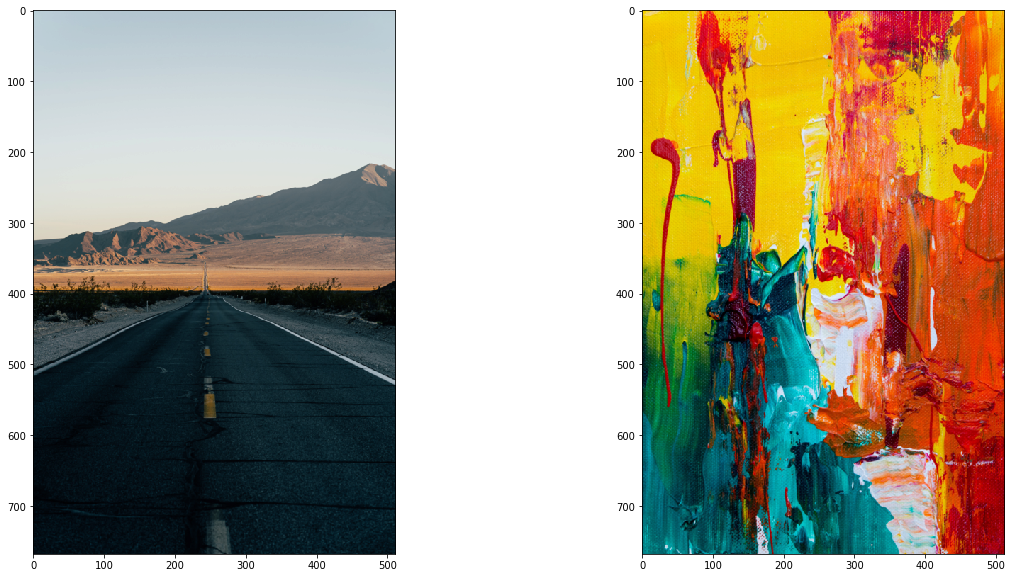

In [45]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# Grabbing content and style features

From the paper we have observed that we can use different layers for both content and style. 

<center><i>"The images shown in Fig 3 were synthesised by matching the content representation on layer ‘conv4 2’ and the style representation on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’"</i>-- from the paper</center>



In [0]:
def get_features_content(image, model, layers=None):

    if layers is None:
        layers = {
                  '21': 'conv4_2',  
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features


def get_features_style(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1', 
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x            
    return features

## Creating two CNN layer one for content and the other one for style

In [0]:
content_features = get_features_content(content, vgg)
style_features = get_features_style(style, vgg)

In [48]:
content_features

{'conv4_2': tensor([[[[ 0.1251,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
  

# Gram Matrix

Gram matrix or gramian matrix is a set of vectors {*v1, v2, v3, v4, vn*} in an inner product space whose entries are given by *G<sub>ij</sub> = < v<sub>i</sub>,v<sub>j</sub> >*.

Which tells us that it is a square matrix of *v*. ie. <code>v*v.T<code>

An important application of gramian is to compute linear independence: a set of vectors are linearly independent if and only if the Gram determinant (the determinant of the Gram matrix) is non-zero.

Convolution layer returns a tuple of output:
  1. Batch size
  2. Depth
  3. height
  4. width


<code>tensor.size </code> will allow us to calculate the above. 



In [0]:
def gramian(tensor):
 
    _, d, h, w = tensor.size() #we don't batch size
    tensor = tensor.reshape(d, h * w) #flattening 
    gram = torch.mm(tensor, tensor.t()) #inner product 
    
    return gram 

In [50]:
style_grams = {layer: gramian(style_features[layer]) for layer in style_features}
style_grams

{'conv1_1': tensor([[ 28182.1484,  15379.1572,  22696.2090,  ...,  29344.1582,
           11693.9082,  23268.4180],
         [ 15379.1572, 288825.5625, 106769.0547,  ...,  58087.2734,
           68150.3047, 130906.8594],
         [ 22696.2090, 106769.0547, 352810.8125,  ...,   2838.4189,
          101594.6016, 154007.0000],
         ...,
         [ 29344.1582,  58087.2734,   2838.4189,  ..., 385818.5000,
           50661.4844,  82913.5312],
         [ 11693.9082,  68150.3047, 101594.6016,  ...,  50661.4844,
          124404.9531,  75258.4453],
         [ 23268.4180, 130906.8594, 154007.0000,  ...,  82913.5312,
           75258.4453, 314219.3438]], device='cuda:0'),
 'conv2_1': tensor([[396219.1875,   5543.4199, 127891.8594,  ..., 140374.5781,
           49592.5781, 155595.8125],
         [  5543.4199,  14494.3730,   5209.1143,  ...,  22626.2070,
            4946.2651,   3288.5959],
         [127891.8594,   5209.1143, 239509.4219,  ...,  74234.1172,
           25546.7109, 110067.6641],


At this point we have to create a third image which will map our operations from content and style onto the third image. 

note: We will use optimise this image to get our desired output. Since our content image will be the main image file we will clone it so that the extract from the both the input will be rendered on the target image

In [0]:
target = content.clone().requires_grad_(True).to(device)

## Weights and Bias

As per the paper 

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

alpha = 1  # alpha
beta = 1e6  # beta

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## Content representation
                  '28': 'conv5_1'}
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
from tqdm import tqdm

show_every = 100

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.001)
steps = 1000  # decide how many iterations to update your image (5000)

for ii in tqdm(range(1, steps+1)):
    
    ## TODO: get the features from your target image    
    ## Then calculate the content loss -- mean square error or L2 norm
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        target_gram = gramian(target_feature)
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    total_loss = alpha * content_loss + beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

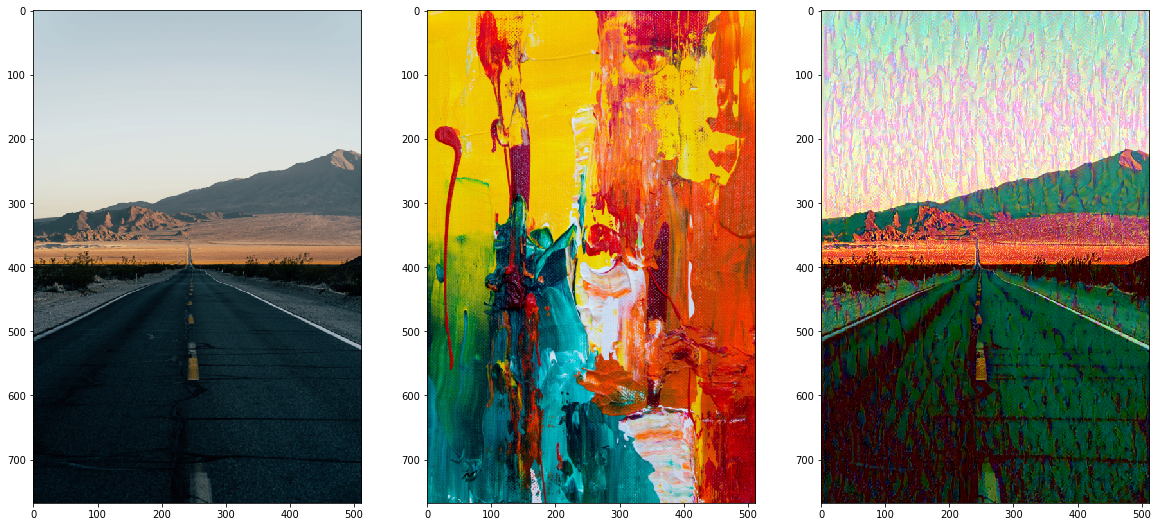

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))